# 
<h1 style="color: teal;"><b>3D Deconvolution Benchmark: Julia</b></h1>

<p style="color: gray;"><b>Análisis de tiempo de procesamiento de imágenes</b></p>

Este notebook realiza varias pruebas con diferentes imágenes para medir el tiempo de procesamiento en cada uno de los casos. El objetivo es ver el tiempo que tarda en realizarse el procesamiento de cada imagen y evaluar la eficiencia de los algoritmos utilizados.

Las pruebas incluyen las siguientes fases:

1. Cargar las imágenes de prueba.
2. Realizar el procesamiento de las imágenes (deconvolución, análisis, etc.).
3. Medir el tiempo de ejecución.

A lo largo del notebook, se utilizarán distintas imágenes para observar cómo varía el tiempo de procesamiento según las imágenes utilizadas.


## 
<hr style="border: 6px solid teal;">
<h1 style="color: gray;">Setup</h1>


<p style="color: red;"><b>IMPORTANTE: </b></p> Ejecutar la siguiente celda antes de comenzar

In [1]:
using DeconvOptim, Images, FFTW, Noise, ImageView, BenchmarkTools, Plots, ColorTypes, Distributed, FileIO

<p style="color: red;"><b>Importante: </b></p>Ejecutar todas las funciones antes de comenzar

### FUNCIONES

Comprobación de cuantos núcleos está usando

In [2]:

println(nprocs())  # Debe devolver 1

1


In [3]:

function load_image_stack(folder_path::String)
    # Listar todos los archivos en la carpeta y ordenar
    files = sort(filter(f -> endswith(f, ".tif") || endswith(f, ".png") || endswith(f, ".jpg"), readdir(folder_path)))

    # Leer la primera imagen para obtener las dimensiones
    first_image = load(joinpath(folder_path, files[1]))
    height, width = size(first_image)

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = Array{Float32, 3}(undef, height, width,length(files))

    # Leer el rango de valores para normalización
    max_val = Float32(maximum(first_image)) # Valor máximo para normalización

    # Cargar cada imagen en la matriz 3D y convertir a Float32
    for (i, file) in enumerate(files)
        image = load(joinpath(folder_path, file))
        image_stack[:, :, i] = Float32.(image) / max_val
    end
    
    return image_stack
end


load_image_stack (generic function with 1 method)

In [4]:

function flipPSF(inPSF)
    # Obtener las dimensiones de la PSF
    Sx, Sy = size(inPSF)
    Sz = 1  # Si la imagen es 2D, la tercera dimensión será de tamaño 1

    if ndims(inPSF) == 3
        Sz = size(inPSF, 3)
    end
    # Crear una matriz de ceros del mismo tamaño que la PSF de entrada
    outPSF = zeros(Float32, Sx, Sy, Sz)
    
    # Invertir la PSF en todas las dimensiones
    for i in 1:Sx
        for j in 1:Sy
            for k in 1:Sz
                outPSF[i, j, k] = Float32(inPSF[Sx - i + 1, Sy - j + 1, Sz - k + 1])
            end
        end
    end
    
    return outPSF
end

flipPSF (generic function with 1 method)

In [5]:
function richardson_lucy_iterative2(measured, psf; 
    psf_bp=nothing,
    regularizer=nothing,
    λ=0.05,
    iterations=100,
    conv_dims=1:ndims(psf),
    threshold = 0,
    progress = nothing)

otf, conv_temp = plan_conv(measured, psf, conv_dims) 
# initializer
### Different PSF inizialization methods are possible generating custom psf_bp using the relative functions 
# if psf_bp == nothing
#     psf_bp = deepcopy(psf)
#     reverse!(psf_bp)
# end
# otf_conj, _ = plan_conv(measured, psf_bp, conv_dims) 
if psf_bp == nothing
otf_conj = conj.(otf)
else
otf_conj, _ = plan_conv(measured, psf_bp, conv_dims) 
end
# Apply threshold
rec =  map(x -> x >= threshold ? x : threshold, measured) 

#### THIS PART NEED TO BE DEBUGGED!!!
# buffer for gradient
# we need Base.invokelatest because of world age issues with generated
# regularizers
buffer_grad =  let 
if !isnothing(regularizer)
Base.invokelatest(DeconvOptim.gradient, regularizer, rec)[1]
else
nothing
end
end

∇reg(x) = buffer_grad .= Base.invokelatest(DeconvOptim.gradient, regularizer, x)[1]

buffer = copy(measured)

iter_without_reg(rec) = begin
buffer .= measured ./ (conv_temp(rec, otf))
conv_temp(buffer, otf_conj)
end
iter_with_reg(rec) = buffer .= (iter_without_reg(rec) .- λ .* ∇reg(rec))

iter = isnothing(regularizer) ? iter_without_reg : iter_with_reg

# the loss function is only needed for logging, not for LR itself
loss(myrec) = begin
fwd = conv_temp(myrec, otf)
return sum(fwd .- measured .* log.(fwd))
end

# logging part
tmp_time = 0.0
if progress !== nothing
record_progress!(progress, rec, 0, loss(rec), 0.0, 1.0)
tmp_time=time()
end
code_time = 0.0

# do actual optimization
for i in 1:iterations
rec .*= iter(rec)
if progress !== nothing
# do not count the time for evaluating the loss here.
code_time += time() .- tmp_time
record_progress!(progress, copy(rec), i, loss(rec), code_time, 1.0)
tmp_time=time()
end
end

return rec
end


richardson_lucy_iterative2 (generic function with 1 method)

In [6]:
function BackProjector(PSF_fp; bp_type="traditional", alpha=0.001, beta=1, n=10, resFlag=1, iRes=[0, 0, 0], verboseFlag=false)
    # Initialize dimensions
    dims = ndims(PSF_fp)
    if dims == 2
        Sx, Sy = size(PSF_fp)
        Sz = 1
    elseif dims == 3
        Sx, Sy, Sz = size(PSF_fp)
    else
        error("Input PSF must be 2D or 3D")
    end

    # Scx, Scy, Scz = (Sx + 1) / 2, (Sy + 1) / 2, (Sz + 1) / 2

    if verboseFlag
        println("Back projector type: $bp_type")
    end

    # Flip PSF
    flippedPSF = deepcopy(PSF_fp)
    reverse!(flippedPSF)

    if bp_type == "traditional"
        PSF_bp = flippedPSF
        OTF_bp = fft(ifftshift(PSF_bp))

    else

        # Fourier Transform of flipped PSF
        OTF_flip = fft(ifftshift(flippedPSF))
        OTF_abs = fftshift(abs.(OTF_flip))
        OTFmax = maximum(OTF_abs)

        if bp_type == "wiener"
            OTF_flip_norm = OTF_flip / OTFmax
            OTF_bp = OTF_flip_norm ./ (abs.(OTF_flip_norm).^2 .+ alpha)
            PSF_bp = fftshift(real(ifft(OTF_bp)))
        else

            # Resolution cutoff
            resx, resy, resz = if resFlag == 0
                FWHMx, FWHMy, FWHMz = size_to_fwhm(Sx, Sy, Sz)
                (FWHMx / √2, FWHMy / √2, FWHMz / √2)
            elseif resFlag == 1
                size_to_fwhm(Sx, Sy, Sz)
            elseif resFlag == 2
                dims == 2 ? (iRes[1], iRes[2], 0) : (iRes[1], iRes[2], iRes[3])
            else
                error("Invalid resFlag: $resFlag. Must be 0, 1, or 2.")
            end

            if bp_type == "gaussian"
                PSF_bp = gen_gaussianPSF(Sx, Sy, Sz, resx, resy, resz, dims)
                OTF_bp = fft(ifftshift(PSF_bp))
            else

                # Pixel size and frequency cutoff
                px, py, pz = 1 / Sx, 1 / Sy, 1 / max(1, Sz)
                tx, ty, tz = 1 / (resx * px), 1 / (resy * py), 1 / (resz * pz)

                if verboseFlag
                    println("Resolution cutoff (spatial): $resx x $resy x $resz")
                    println("Resolution cutoff (Fourier): $tx x $ty x $tz")
                end

                PSF_bp, OTF_bp = nothing, nothing

                # Process each back projector type
                
                if bp_type == "butterworth"
                    PSF_bp, OTF_bp = butterworth_filter(Sx, Sy, Sz, tx, ty, tz, beta, n, dims)
                elseif bp_type == "wiener-butterworth"
                    OTF_abs_norm = OTF_abs / OTFmax
                    PSF_bp, OTF_bp = wiener_butterworth_filter(OTF_flip, OTF_abs_norm, alpha, beta, Sx, Sy, Sz, tx, ty, tz, n, dims)
                else
                    error("Unsupported bp_type: $bp_type")
                end
            end
        end
    end

    return convert(typeof(PSF_fp), PSF_bp), OTF_bp
end


BackProjector (generic function with 1 method)

In [375]:
function plot_orthogonal_views2(volume_3d::Array{<:Real,3}; save_path=nothing, dpi=300)
    # Detectar si el array tiene más slices en la última dimensión y reorganizar
    Z, Y, X = size(volume_3d)
  

    # Cortes centrales
    z_center = fld(Z, 2)
    y_center = fld(Y, 2)
    x_center = fld(X, 2)

    slice_xy = volume_3d[z_center, :, :]   # (Y, X)
    slice_xz = volume_3d[:, y_center, :]   # (Z, X)
    slice_yz = volume_3d[:, :, x_center]   # (Z, Y)

    # Normalización
    norm(s) = (s .- minimum(s)) ./ (maximum(s) - minimum(s) + 1e-9)
    slice_xy_norm = norm(slice_xy)
    slice_xz_norm = norm(slice_xz)
    slice_yz_norm = norm(slice_yz)

    # Rotaciones para alinear visualmente como en Python
    slice_xy_plot = rotl90(slice_xy_norm)                  # abajo izquierda
    slice_xz_plot = rot180(slice_xz_norm)  # arriba derecha
    slice_yz_plot = reverse(slice_yz_norm, dims=1)  # arriba izquierda
    
    # Colormaps fluorescentes tipo Python
    fluorescent_red   = cgrad([RGB(0,0,0), RGB(1,0,0)])
    fluorescent_green = cgrad([RGB(0,0,0), RGB(0,1,0)])
    fluorescent_blue  = cgrad([RGB(0,0,0), RGB(0,0,1)])

    # Layout 2x2
    l= @layout [a b; c d]

    # Plots
    p1 = heatmap(slice_yz_plot, color=fluorescent_green, colorbar=false, aspect_ratio=:equal,
                 framestyle=:none, grid=false, axis=false, bottom_margin=:match)  # arriba izquierda
    p2 = heatmap(slice_xz_plot, color=fluorescent_green, colorbar=false, aspect_ratio=:equal,
                 framestyle=:none, grid=false, axis=false)  # arriba derecha
    p3 = heatmap(slice_xy_plot, color=fluorescent_green, colorbar=false, aspect_ratio=:equal,
                 framestyle=:none, grid=false, axis=false)  # abajo izquierda
    p4 = plot(legend=false, framestyle=:none, axis=false, aspect_ratio=:equal, grid=false)       # hueco abajo derecha

    plt = plot(
    p1, p2, p3, p4, 
    layout=l, 
    grid=false,
    axis=false, 
    size=(700,700), 
    dpi=dpi
)


    display(plt)

    if save_path !== nothing
        savefig(plt, save_path)
    end
end


plot_orthogonal_views2 (generic function with 1 method)

In [357]:
function guardar_cortes_centrales(volumen_3d::Array{<:Number,3}; 
    carpeta="vistas", 
    formato="png", 
    color=fluorescent_red)

    isdir(carpeta) || mkdir(carpeta)

    Z, Y, X = size(volumen_3d)
  

    # Cortes centrales
    z_center = fld(Z, 2)
    y_center = fld(Y, 2)
    x_center = fld(X, 2)

    slice_xy = volumen_3d[z_center, :, :]   # (Y, X)
    slice_xz = volumen_3d[:, y_center, :]   # (Z, X)
    slice_yz = volumen_3d[:, :, x_center]   # (Z, Y)

    # Normalización
    norm(s) = (s .- minimum(s)) ./ (maximum(s) - minimum(s) + 1e-9)
    slice_xy_norm = norm(slice_xy)
    slice_xz_norm = norm(slice_xz)
    slice_yz_norm = norm(slice_yz)

    # Rotaciones para alinear visualmente como en Python
    slice_xy_plot = rotl90(slice_xy_norm)                  # abajo izquierda
    slice_xz_plot = rot180(slice_xz_norm)  # arriba derecha
    slice_yz_plot = reverse(slice_yz_norm, dims=1)  # arriba izquierda

    function guardar_heatmap(data, nombre)
    plt = heatmap(data, 
    color=color, 
    colorbar=false, 
    aspect_ratio=:equal, 
    framestyle=:none, 
    grid=false, 
    axis=nothing,
    size=(600,600)
    )
    savefig(plt, joinpath(carpeta, "$nombre.$formato"))
    end

    guardar_heatmap(slice_yz_plot, "vista_xy")
    guardar_heatmap(slice_xz_plot, "vista_xz")
    guardar_heatmap(slice_xy_plot, "vista_yz")

    println("✅ Cortes centrales guardados en '$carpeta'")
end


guardar_cortes_centrales (generic function with 1 method)

## 
<hr style="border: 6px solid teal;">
<h1 style="color: teal;"><b>Test Image</b></h1>

Comenzamos cargando la imagen con ruido y la PSF que se van a emplear en esta primera prueba:

In [138]:
# Cargamos la imagen (esta imagen no tiene ruido)
img = convert(Array{Float32}, channelview(load("ImagenesEmpleadas3D/simple_3d_ball.tif")));

# Cargamos la imagen con ruido
img_n_julia = convert(Array{Float32}, channelview(load("ImagenesEmpleadas3D/simple_3d_ball_blurred.tif")));

# Caragamos la PSF y la normalizamos
psf_test_julia = ifftshift(convert(Array{Float32}, channelview(load("ImagenesEmpleadas3D/simple_3d_psf.tif"))));

# Agregar un pequeño valor para evitar divisiones por cero
epsilon = eps(Float32)

# Asegurarse de que el PSF no tenga valores cero y normalizarlo
psf_test_julia = psf_test_julia .+ epsilon;
psf_test_julia ./= sum(psf_test_julia);

Verificamos que el tamaño y el tipo de la imagen y PSF sea el mismo

In [139]:
println("Tamaño de la imagen con ruido: ", size(img_n_julia))
println("Tipo de elemento de la imagen con ruido: ", eltype(img_n_julia))
println("Tamaño de la PSF: ",size(psf_test_julia))
println("Tipo de elemento de la PSF: ", eltype(psf_test_julia))

Tamaño de la imagen con ruido: (64, 64, 64)
Tipo de elemento de la imagen con ruido: Float32
Tamaño de la PSF: (64, 64, 64)
Tipo de elemento de la PSF: Float32


<h4 style="color: purple;">@richardson_lucy_iterative2</h4>

Realizaremos una primera prueba sin regularizador y posteriormente una con regularizador (no estamos usando back projector):

SIN REGULARIZADOR

In [140]:
sin_reg = richardson_lucy_iterative2(img_n_julia, psf_test_julia, regularizer=nothing, iterations=30);

println(size(sin_reg))
println("res element type: ", eltype(sin_reg))

(64, 64, 64)
res element type: Float32


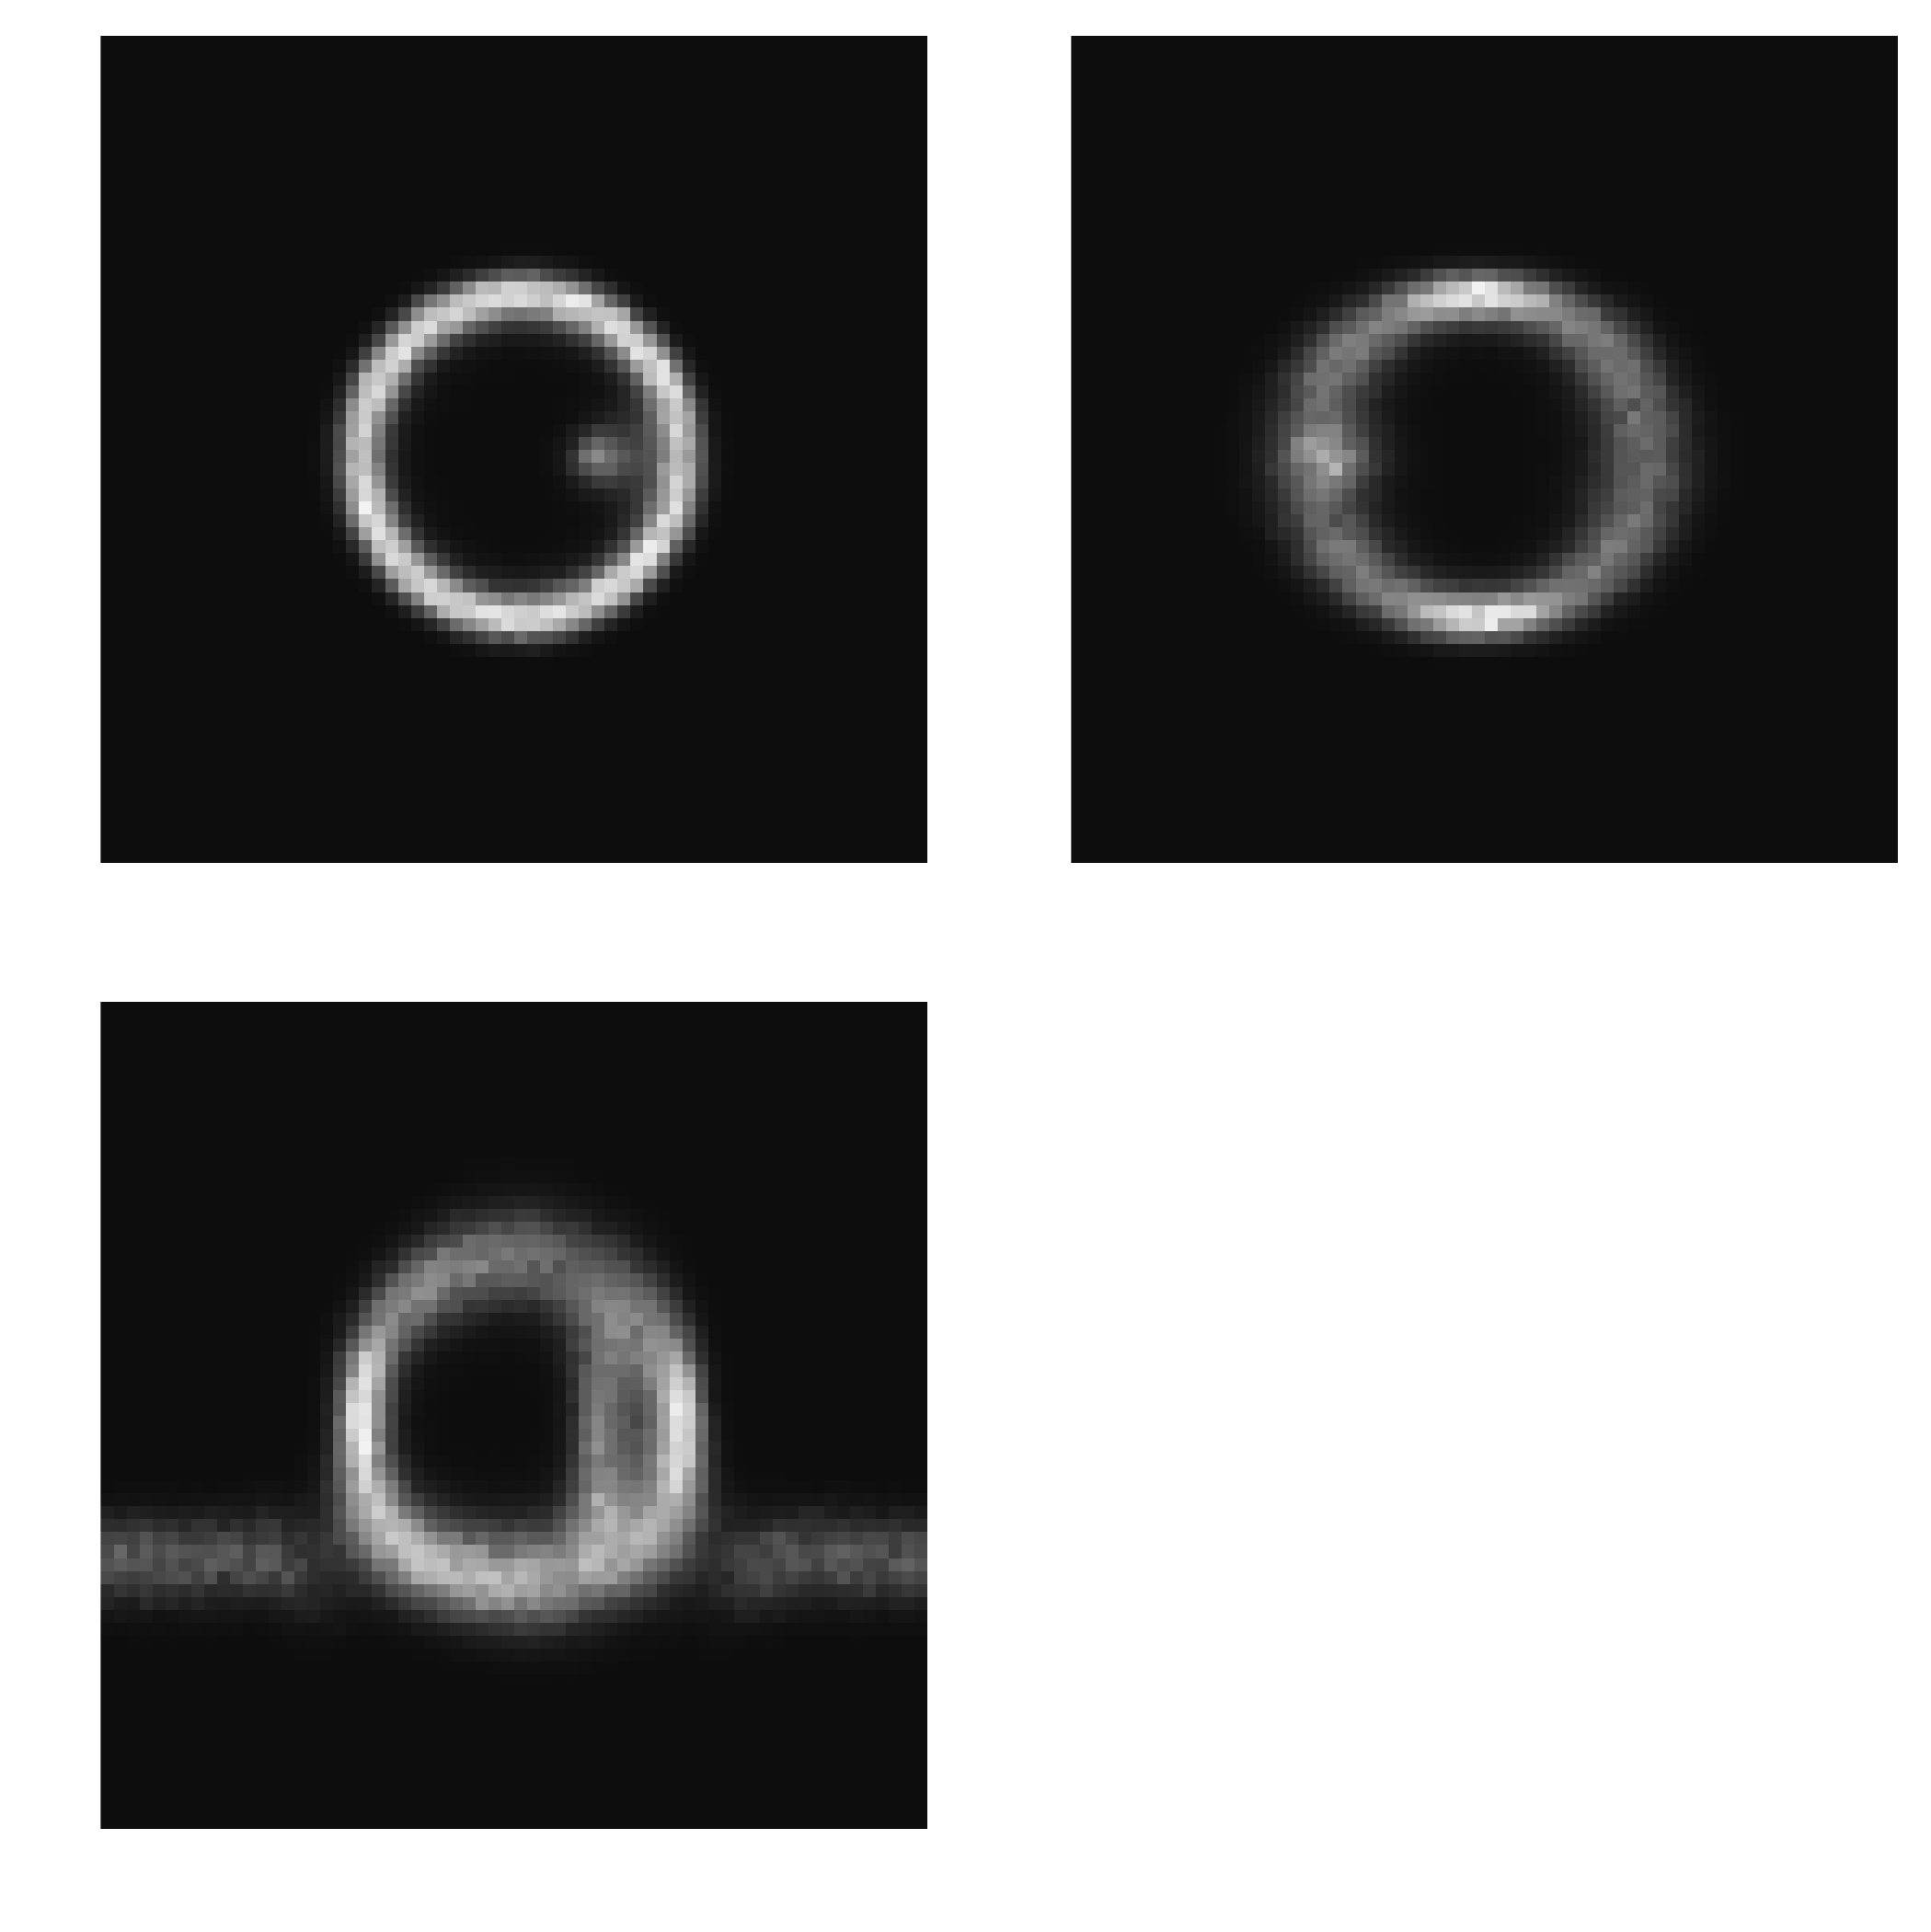

"/Users/yi/TFGNotebook/3D_ortogonal_JULIA_sin_reg_TESTIMAGE.png"

In [182]:
plot_orthogonal_views2(sin_reg, save_path="3D_ortogonal_JULIA_sin_reg_TESTIMAGE.png")

CON REGULARIZADOR

In [142]:
reg = TV(num_dims=3, sum_dims=[1, 2, 3]);

In [143]:
con_reg = richardson_lucy_iterative2(img_n_julia, psf_test_julia, regularizer=reg, iterations=30);
println(size(con_reg))
println("res2 element type: ", eltype(con_reg))

(64, 64, 64)
res2 element type: Float32


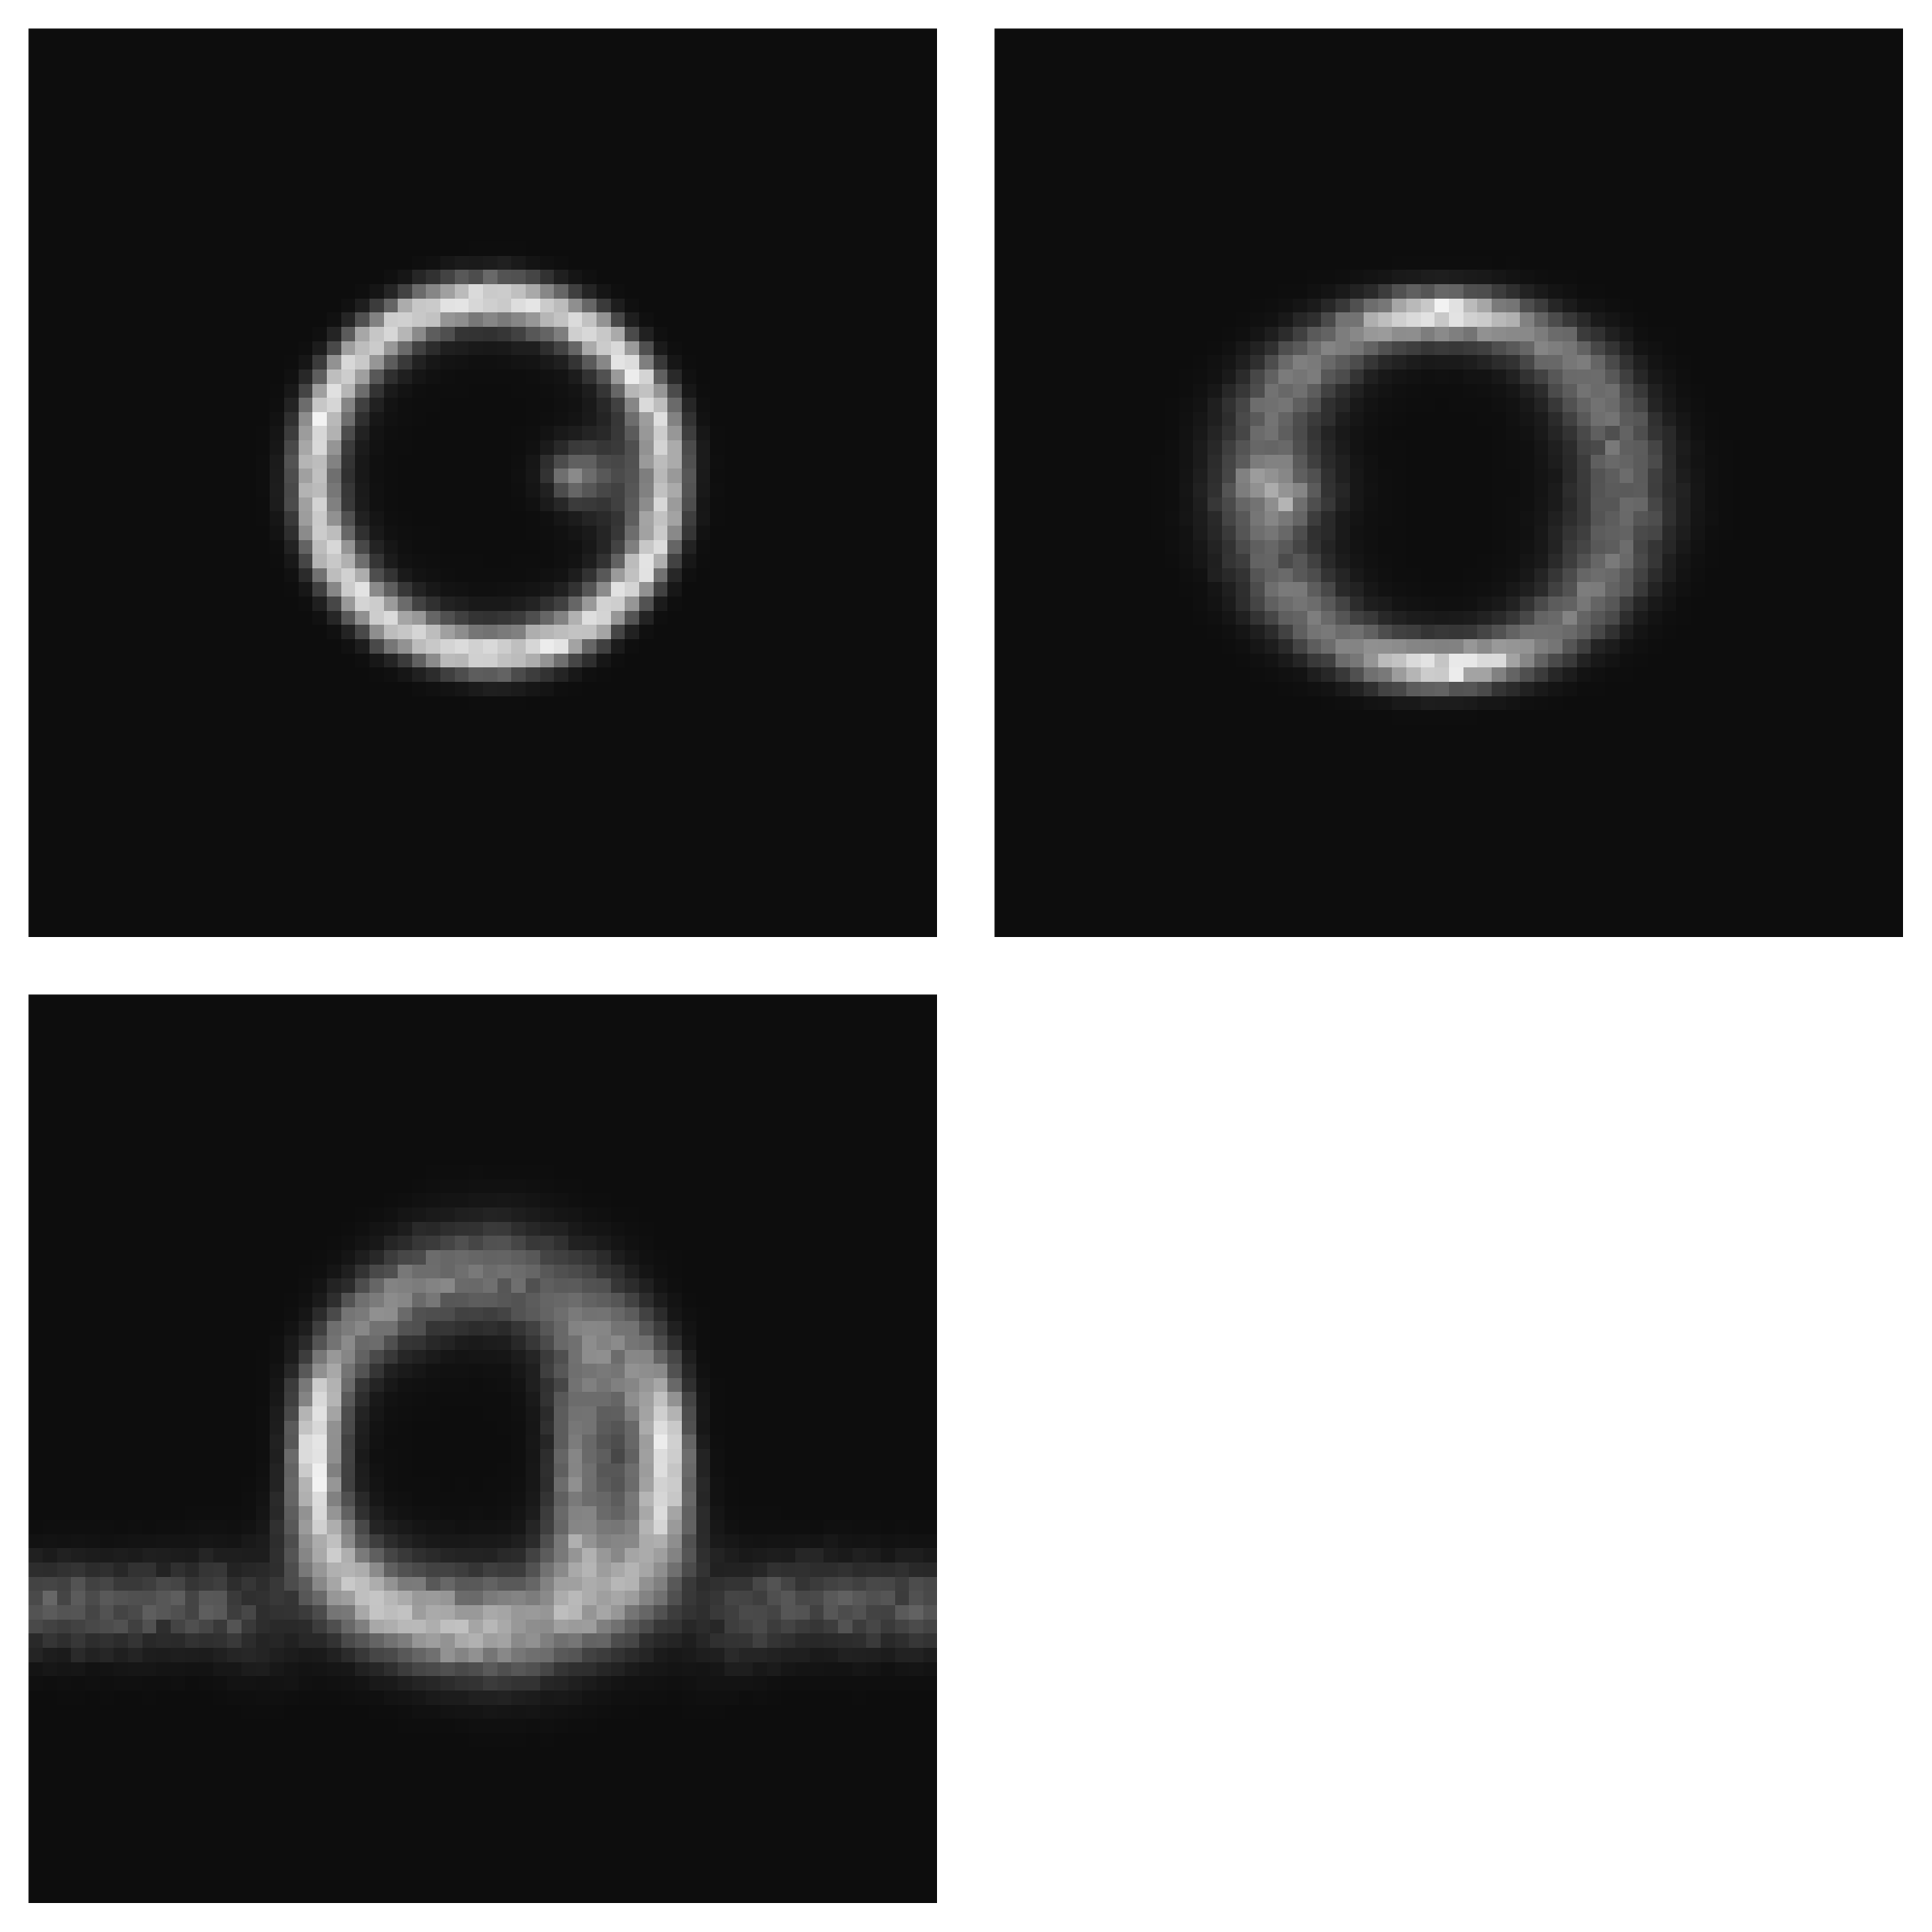

"/Users/yi/TFGNotebook/3D_ortogonal_JULIA_con_reg_TESTIMAGE.png"

In [144]:
plot_orthogonal_views(sin_reg, save_path="3D_ortogonal_JULIA_con_reg_TESTIMAGE.png")

In [145]:
# Verificar valores mínimos y máximos en las matrices resultantes
println("Máximo valor en la imagen con regularizador: ", maximum(con_reg))
println("Mínimo valor en la imagen sin regularizador: ", minimum(con_reg))
println("Máximo valor en la imagen sin regularizador: ", maximum(sin_reg))
println("Mínimo valor en la imagen sin regularizador: ", minimum(sin_reg))
println("Máximo valor en la imagen con ruido: ", maximum(img_n_julia))
println("Mínimo valor en la imagen con ruido: ", minimum(img_n_julia))


Máximo valor en la imagen con regularizador: 0.41684645
Mínimo valor en la imagen sin regularizador: -4.2484828e-13
Máximo valor en la imagen sin regularizador: 0.652214
Mínimo valor en la imagen sin regularizador: 0.0
Máximo valor en la imagen con ruido: 0.2627451
Mínimo valor en la imagen con ruido: 0.0


Mostramos las imágenes resultantes, en concreto el stack 32 (arriba) y el 38 (abajo):
- La primera imagen es la imagen original
- La segunda imagen es la imagen con ruido
- La tercera imagen es la imagen con ruido deconvolucionada sin regularizador
- La cuarta imagen es la imagen con ruido deconvolucionada con regularizador

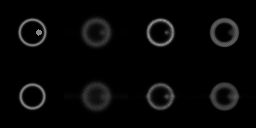

In [54]:
img_comb1 = [img[:, : ,32] img_n_julia[:, :, 32] sin_reg[:, :, 32] con_reg[:, :, 32]]
img_comb2 = [img[:, : ,38] img_n_julia[:, :, 38] sin_reg[:, :, 38] con_reg[:, :, 38] ]

img_comb = cat(img_comb1, img_comb2, dims=1)
#img_comb ./= maximum(img_comb)

colorview(Gray, img_comb)

<h3 style="color: green;">@ Benchmark</h3>

En este paso, se llevará a cabo un benchmark para medir el tiempo que tarda la función de deconvolución en procesar la imagen. Utilizaremos la macro @benchmark para realizar la medición, y se podrá especificar el número de muestras (samples) a utilizar para obtener una estimación más precisa del tiempo de ejecución.

In [55]:
@benchmark richardson_lucy_iterative2(img_n_julia, psf_test_julia, regularizer=nothing, iterations=30)  samples=50 evals=1

BenchmarkTools.Trial: 50 samples with 1 evaluation.
 Range (min … max):  47.047 ms … 59.202 ms  ┊ GC (min … max): 0.00% … 19.19%
 Time  (median):     47.624 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   47.974 ms ±  1.832 ms  ┊ GC (mean ± σ):  0.71% ±  3.08%

  ▇▃██                                                         
  ████▇▆▁▃▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  47 ms           Histogram: frequency by time        59.2 ms <

 Memory estimate: 7.10 MiB, allocs estimate: 94.

In [56]:
@benchmark richardson_lucy_iterative2(img_n_julia, psf_test_julia, regularizer=reg, iterations=30) samples=50 evals=1

BenchmarkTools.Trial: 50 samples with 1 evaluation.
 Range (min … max):  83.771 ms … 276.413 ms  ┊ GC (min … max): 0.00% … 68.60%
 Time  (median):     85.778 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   90.081 ms ±  26.952 ms  ┊ GC (mean ± σ):  5.12% ±  9.73%

  █                                                             
  █▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▁
  83.8 ms         Histogram: frequency by time          276 ms <

 Memory estimate: 38.15 MiB, allocs estimate: 1925.

## 
<hr style="border: 6px solid teal;">
<h1 style="color: teal;"><b>Cell 3D</b></h1>

Cargamos la imagen con ruido y la PSF y normalizamos ambas:

In [146]:
# Cargamos la imagen con ruido y la PSF
cell = convert(Array{Float32}, channelview(load("ImagenesEmpleadas3D/3Dconvolved_cell.tif")));
cell_psf = convert(Array{Float32}, channelview(load("ImagenesEmpleadas3D/3Dconvolved_cell_psf.tif")));

# Normalizamos ambas
cell /= maximum(cell);
cell_psf /= maximum(cell_psf);

# Verificar las dimensiones de las matrices 3D
println("Tamaño de la matriz 3D de la imagen: ", size(cell))
println("Tipo de elemento de la imagen: ", eltype(cell))
println("Tamaño de la matriz 3D de la PSF: ", size(cell_psf))

Tamaño de la matriz 3D de la imagen: (71, 71, 60)
Tipo de elemento de la imagen: Float32
Tamaño de la matriz 3D de la PSF: (71, 71, 60)


Visualizamos la imagen borrosa y la PSF con la que se va a trabajar:

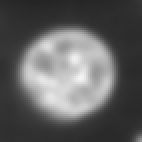

In [148]:
# Imagen original
colorview(Gray, cell[:,:,30])

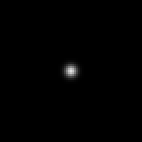

In [149]:
# PSF
colorview(Gray, cell_psf[:,:,30])

<h4 style="color: purple;">@deconvolution</h4>

Realizamos la deconvolución  con la función @Deconvolution sin regularizador y visualizamos la imagen resultante:

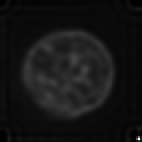

In [60]:
cell_res, cell_o_res = deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=30);

# Visualizamos las imagen resultante, solo el Stack 30
colorview(Gray, cell_res[:,:,30]/maximum(cell_res[:,:,30]))

<h4 style="color: purple;">@richardson_lucy_iterative2</h4>

Usamos la función @richardson_lucy_iterative2 sin regularizador (no estamos usando Backprojector) y visualizamos la imagen resultante:

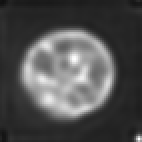

In [150]:
deconcell_res = richardson_lucy_iterative2(cell, ifftshift(cell_psf), regularizer=nothing, iterations=30);

# Visualizamos las imagen resultante, solo el Stack 30
colorview(Gray, deconcell_res[:,:,30]/maximum(deconcell_res[:,:,30]))

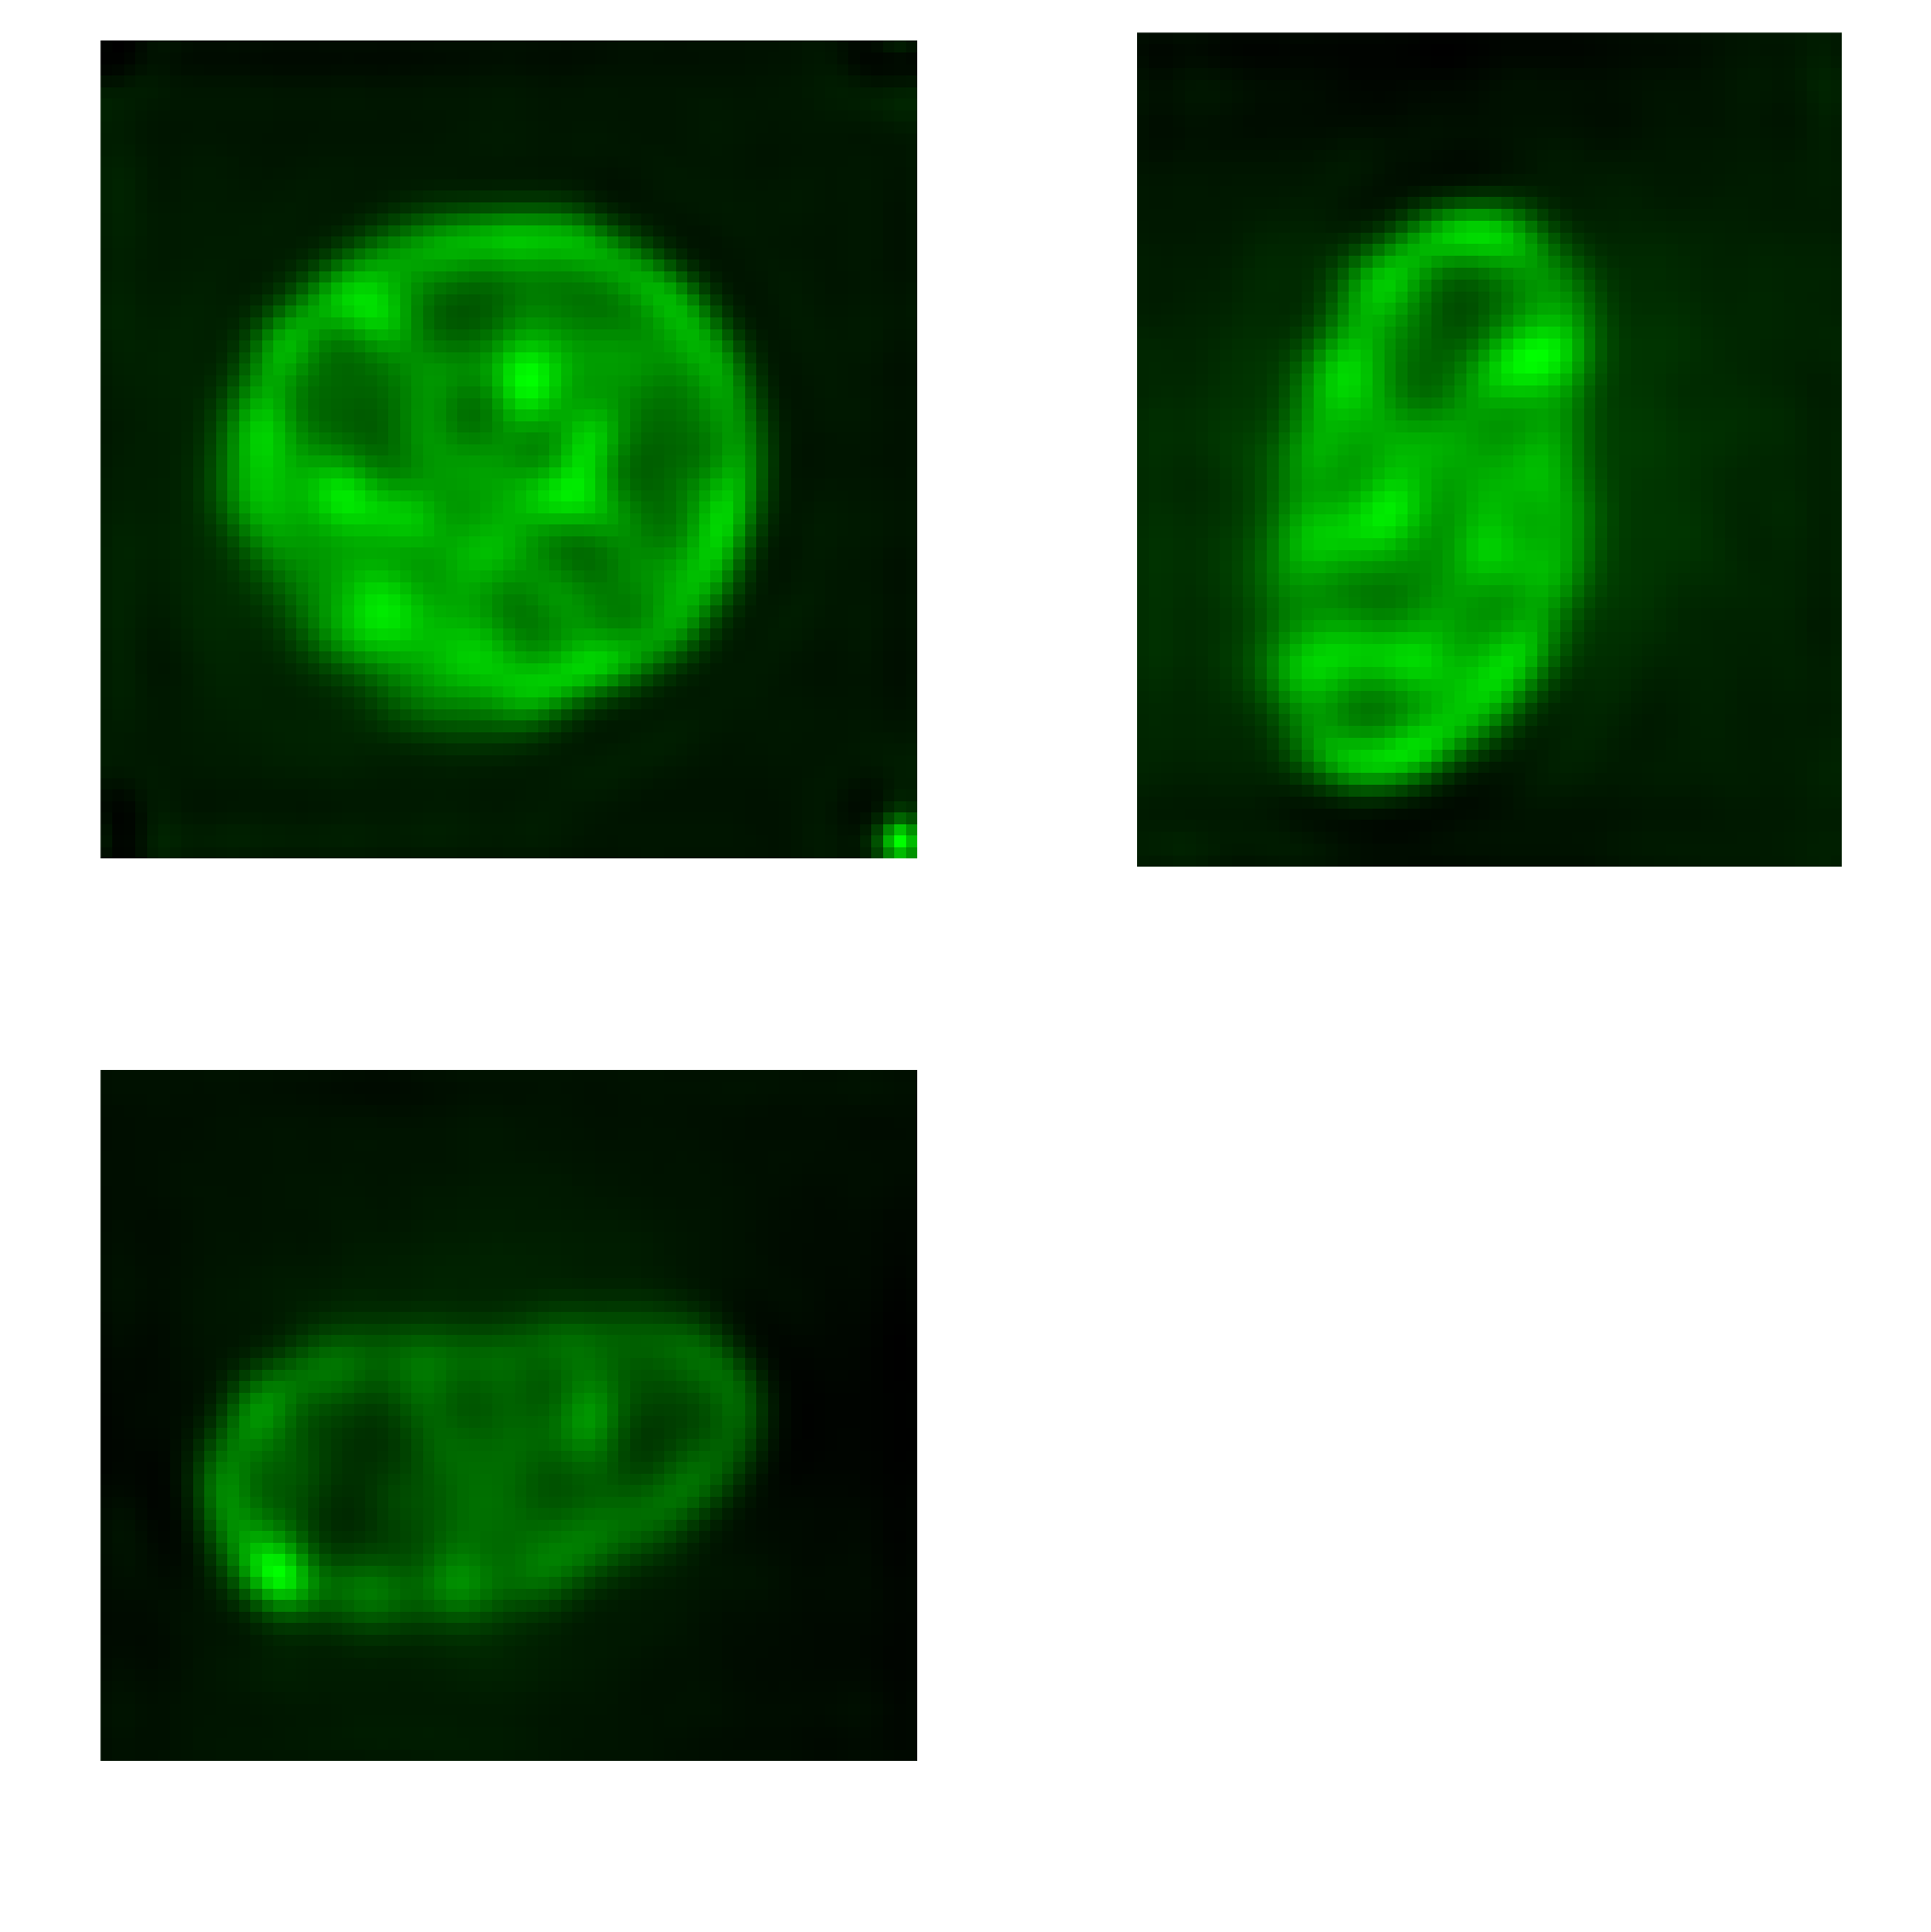

"/Users/yi/TFGNotebook/3D_ortogonal_JULIA_cell3d_deconv.png"

In [376]:
plot_orthogonal_views2(deconcell_res, save_path="3D_ortogonal_JULIA_cell3d_deconv.png")

<h3 style="color: green;">@ Benchmark</h3>

In [152]:
@benchmark richardson_lucy_iterative2(cell, ifftshift(cell_psf), regularizer=nothing, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  556.380 ms … 580.093 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     564.704 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   565.321 ms ±   6.787 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █            █ █   █   ██ █                                 █  
  █▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁█▁▁▁██▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  556 ms           Histogram: frequency by time          580 ms <

 Memory estimate: 9.28 MiB, allocs estimate: 96.

Con la función @Deconvolution se puede observar que tarda más

In [40]:
@benchmark deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.037 s …  1.049 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.045 s             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.044 s ± 5.618 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                      █                          █    █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  1.04 s        Histogram: frequency by time        1.05 s <

 Memory estimate: 200.60 MiB, allocs estimate: 5836.

## 
<hr style="border: 6px solid teal;">
<h1 style="color: teal;"><b>Cube of Spherical Beads</b></h1>

In [153]:
# Cargamos la imagen

cube = convert(Array{Float32}, channelview(load("ImagenesEmpleadas3D/cube_convolved.tif")));

# Cargamos la psf

cubePSF = convert(Array{Float32}, channelview(load("ImagenesEmpleadas3D/cube_PSF.tif")));

# Normalizamos
cube /= maximum(cube);
cubePSF /= maximum(cubePSF);

# Verificar las dimensiones de las matrices 3D
println("Tamaño de la matriz 3D de la imagen: ", size(cube))
println("Tipo de elemento de la imagen: ", eltype(cube))
println("Tamaño de la matriz 3D de la PSF: ", size(cubePSF))

Tamaño de la matriz 3D de la imagen: (128, 128, 128)
Tipo de elemento de la imagen: Float32
Tamaño de la matriz 3D de la PSF: (128, 128, 128)


Visualizamos la imagen original:

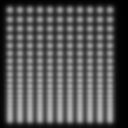

In [154]:
colorview(Gray, cube[:,:,30])

<h4 style="color: purple;">@deconvolution</h4>

Usamos la función @Deconvolution y vemos el resultado:

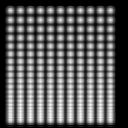

In [44]:
number_of_iterations = 30

cube_res, cube_ores = deconvolution(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations);

colorview(Gray, cube_res[:,:,30]/maximum(cube_res[:,:,30]))

<h4 style="color: purple;">@richardson_lucy_iterative2</h4>

Usamos la función @richardson_lucy_iterative2 sin regularizador (no estamos usando Backprojector) y visualizamos la imagen resultante:

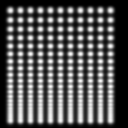

In [157]:
number_of_iterations = 30
deconCube = richardson_lucy_iterative2(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations);

colorview(Gray, deconCube[:,:,30]/maximum(deconCube[:,:,30]))

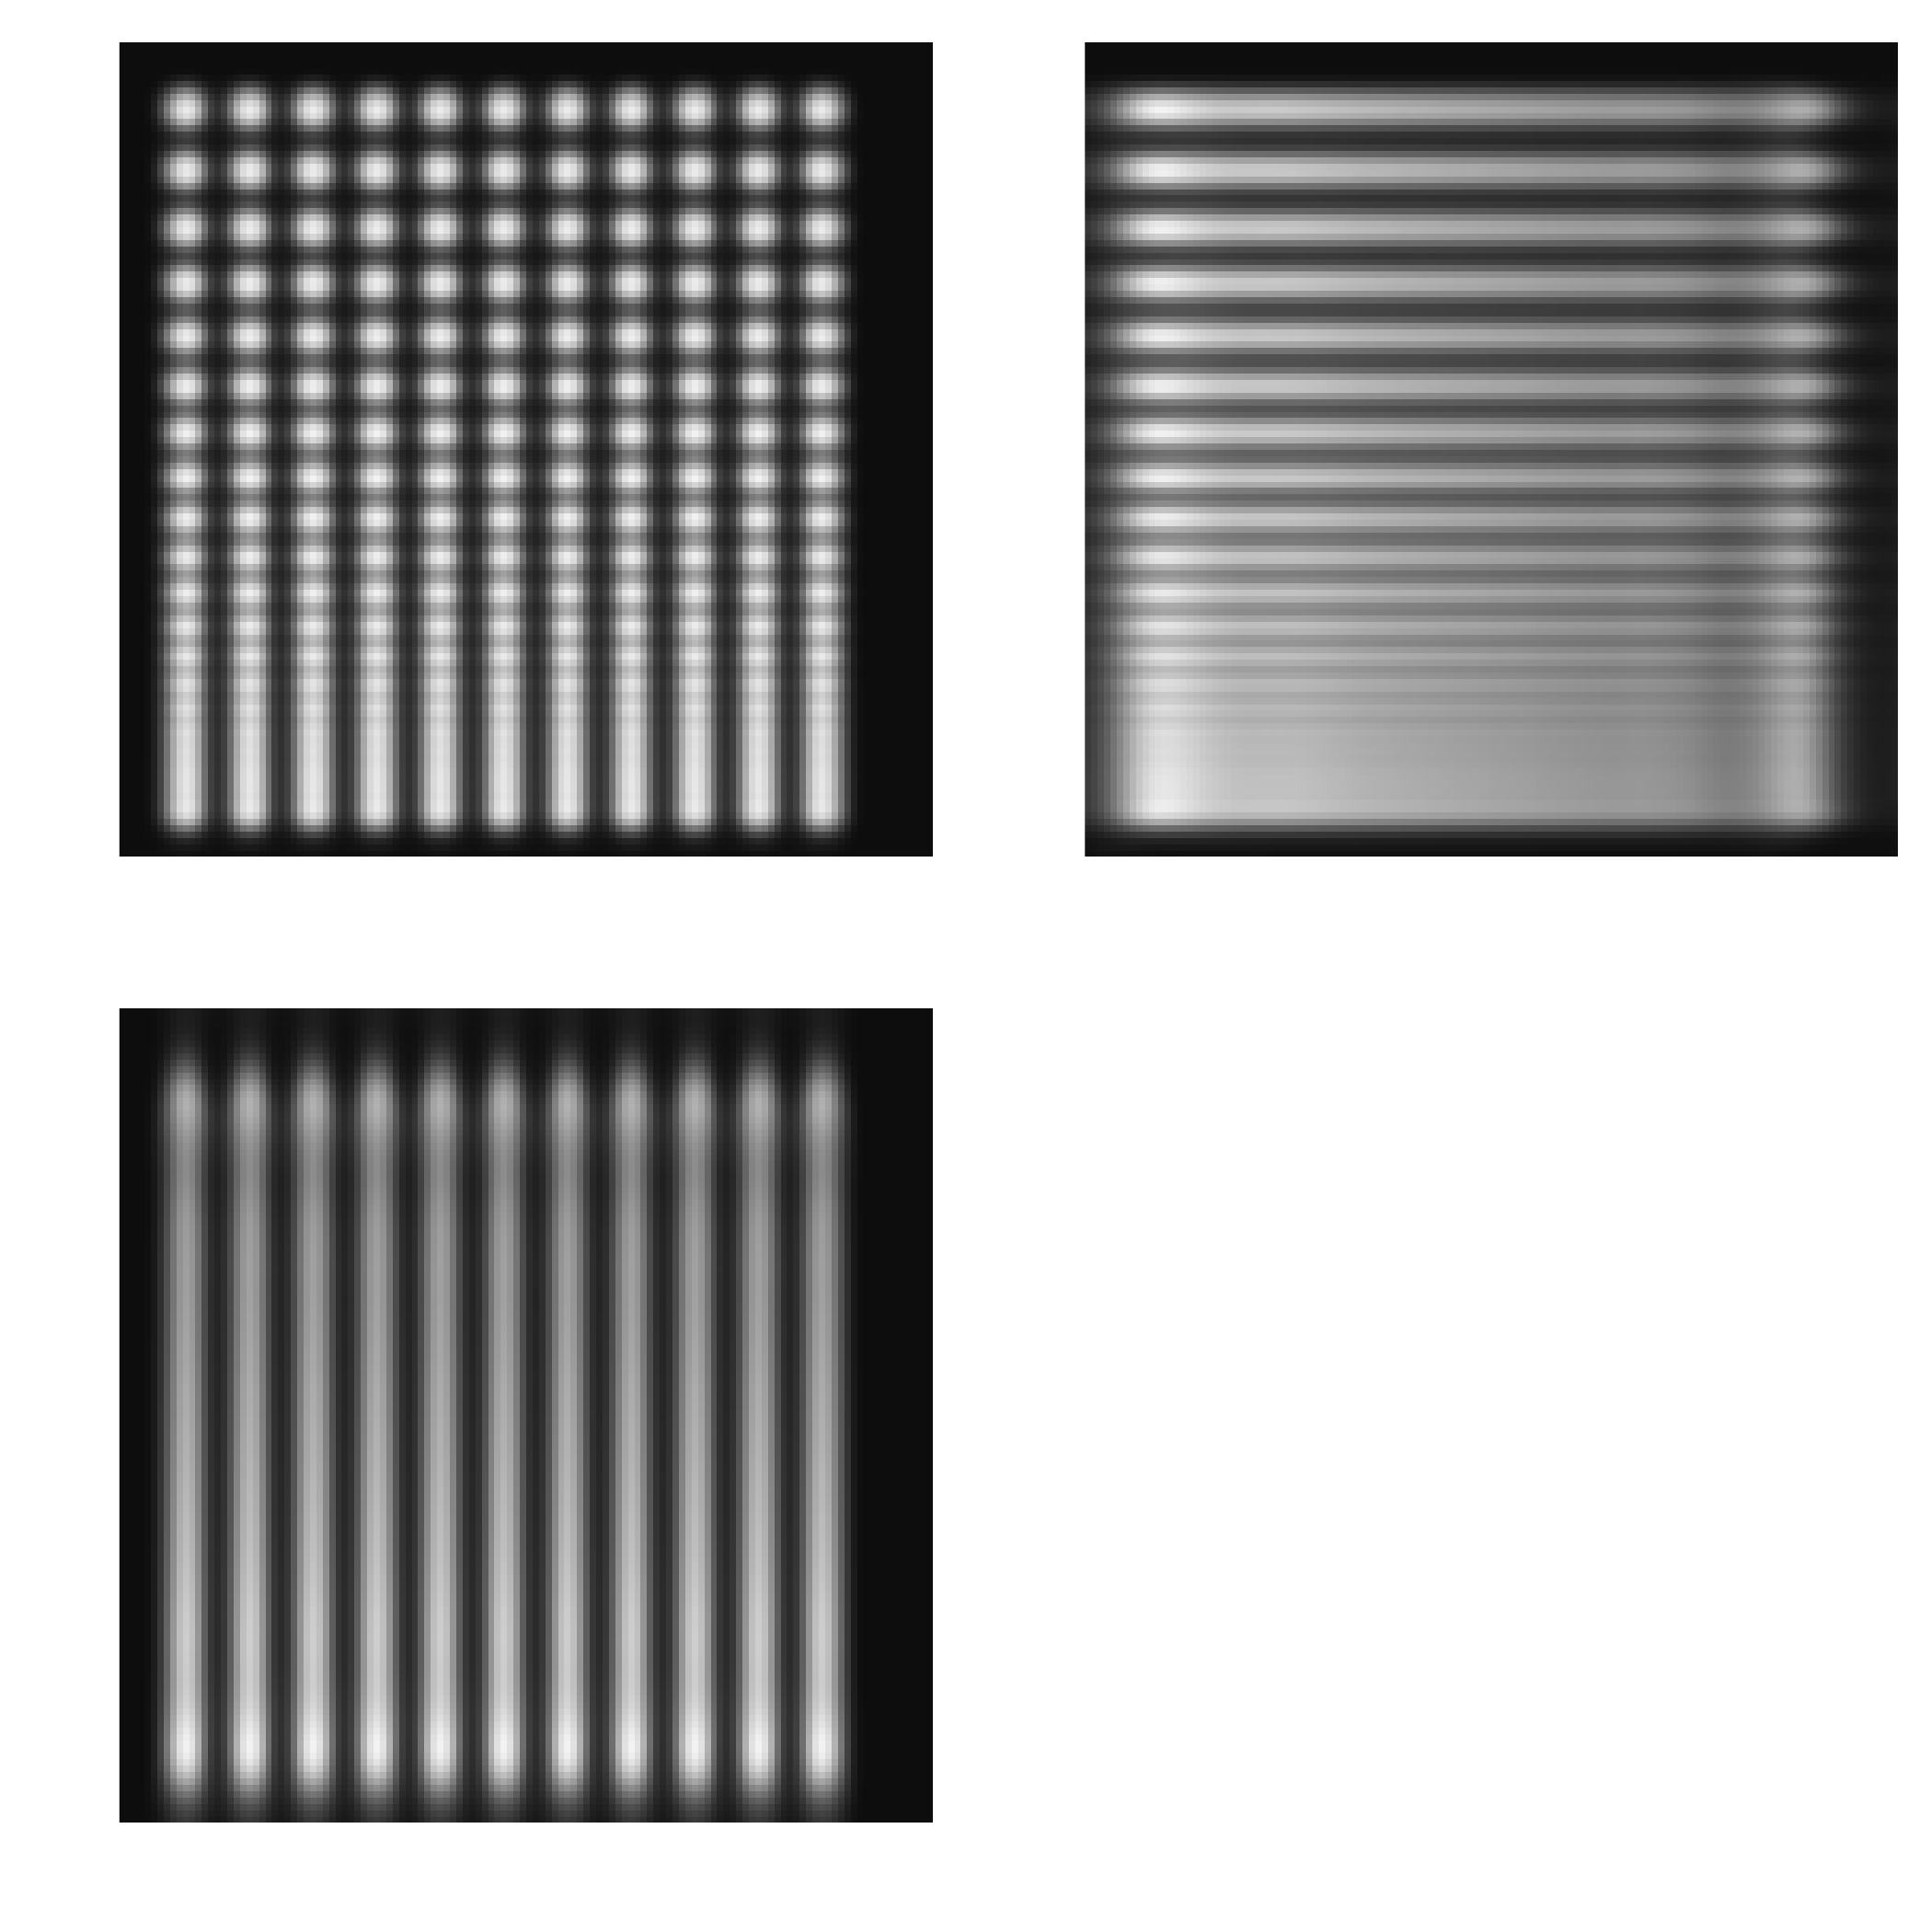

"/Users/yi/TFGNotebook/3D_ortogonal_JULIA_cube_deconv.png"

In [161]:
plot_orthogonal_views2(deconCube, save_path="3D_ortogonal_JULIA_cube_deconv.png")

<h3 style="color: green;">@ Benchmark</h3>

In [158]:
@benchmark richardson_lucy_iterative2(cube, ifftshift(cubePSF), regularizer=nothing, iterations=30) samples=10 evals=1

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  571.429 ms … 645.274 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     633.937 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   624.450 ms ±  27.907 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁                       ▁                         ▁▁      ▁ █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁█▁█ ▁
  571 ms           Histogram: frequency by time          645 ms <

 Memory estimate: 64.38 MiB, allocs estimate: 96.

In [47]:
@benchmark deconvolution(cube, ifftshift(cubePSF), regularizer=nothing, iterations=30) samples=10 evals=1

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.287 s …  2.300 s  ┊ GC (min … max): 7.77% … 7.75%
 Time  (median):     2.294 s             ┊ GC (median):    7.76%
 Time  (mean ± σ):   2.294 s ± 8.745 ms  ┊ GC (mean ± σ):  7.76% ± 0.02%

  █                                                      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.29 s        Histogram: frequency by time         2.3 s <

 Memory estimate: 1.36 GiB, allocs estimate: 5849.

## 
<hr style="border: 6px solid teal;">

<h1 style="color: teal;"><b>C. elegans embryo</b></h1>



Trabajaremos con el Stack 52 y con un tamaño de Imagen y PSF igual, tenemos tres canales Rojo, Verde y Azul, que se procesarán de manera independiente y posteriormente se combinarán.

In [347]:
# Colormaps fluorescentes
fluorescent_red   = cgrad([RGB(0,0,0), RGB(1,0,0)])
fluorescent_green = cgrad([RGB(0,0,0), RGB(0,1,0)])
fluorescent_blue  = cgrad([RGB(0,0,0), RGB(0,0,1)]);

### EJEMPLOS

In [29]:
# Crear una matriz de unos de 5x5
imageStackT = ones(5, 5)

# Asignar valores a posiciones específicas
imageStackT[2, 2] = 2.5
imageStackT[3, 3] = 2.8
imageStackT[4, 4] = 2
imageStackT[2, 3] = 1.5
imageStackT[2, 4] = 2.5
imageStackT[3, 2] = 2.8
imageStackT
#imageStackT = imageStackT/sum(imageStackT)


5×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0
 1.0  2.5  1.5  2.5  1.0
 1.0  2.8  2.8  1.0  1.0
 1.0  1.0  1.0  2.0  1.0
 1.0  1.0  1.0  1.0  1.0

In [30]:
# Crear una matriz de ceros de 5x5
psfStackT = zeros(5, 5)

# Asignar el valor 1 a la posición (3,3)
psfStackT[3, 3] = 1
psfStackT[2, 2] = 1
psfStackT[2, 3] = 1
psfStackT[2, 4] = 1
psfStackT[3, 2] = 1
psfStackT[3, 4] = 1
psfStackT[4, 2] = 1
psfStackT[4, 3] = 1
psfStackT[4, 4] = 1
psfStackT

5×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [31]:
flipPSF(psfStackT)

5×5×1 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [32]:
devonvTEST = richardson_lucy_iterative2(imageStackT, ifftshift(psfStackT), regularizer=nothing, iterations=50)

5×5 Matrix{Float64}:
 1.22391   0.297604   2.01193    0.751464  1.44046
 1.71185   2.40018    3.06463    0.68811   0.063972
 1.02798   0.452696   7.0543     0.918766  1.14357
 1.36272   1.99793    1.12076    1.306     0.257754
 0.150592  0.0164152  0.0290237  0.304646  2.30276

###
<h1 style="color: orange;">Canal 1</h1>

Comenzamos cargando las imágenes del Canal 1:

In [174]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = "/Users/yi/TFGNotebook/CElegans-CY3"
psfPath = "/Users/yi/TFGNotebook/PSF-CElegans-CY3"

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[1:356, 1:336, :]
psf_stack = load_image_stack(psfPath)[179:534, 169:504,:]; #mitad +152

Vemos las dimensiones de las matrices 3D que se han formado con las imágenes que se han cargado previamente, el tamaño de la imagen y la PSF debe coincidir

In [175]:

# Verificar las dimensiones de las matrices 3D
println("Tamaño de la matriz 3D de la imagen: ", size(image_stack))
println("Tipo de elemento de la imagen: ", eltype(image_stack))
println("Tamaño de la matriz 3D de la PSF: ", size(psf_stack))

#image_stack[1:356, 1:336,52] #Descomentar si se quieren ver los elementos por los que está formado el Stack 52 de la matriz

Tamaño de la matriz 3D de la imagen: (356, 336, 104)
Tipo de elemento de la imagen: Float32
Tamaño de la matriz 3D de la PSF: (356, 336, 104)


Descomentar la siguiente celda si se desea guardar la imágen original con la que se va a trabajar:

In [35]:
#save("imagenOriginal_CANAL1.png", image_stack[52, :, :]/maximum(image_stack))

Visualizamos el Stack 52 de la PSF con la que vamos a trabajar:

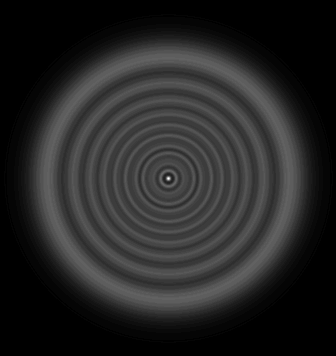

In [176]:
#Visualización de la PSF
colorview(Gray, psf_stack[:,:,1]/maximum(psf_stack[:,:,1]))

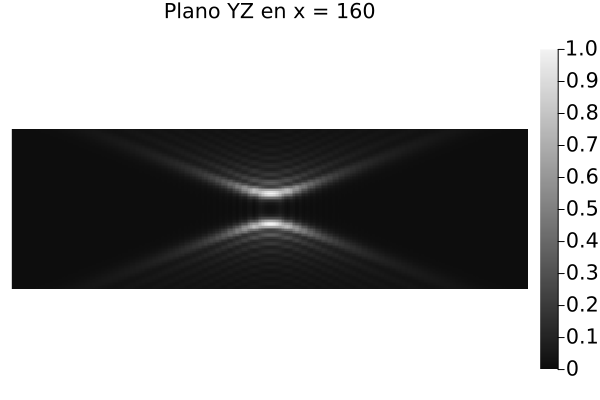

In [64]:
using Plots

x = 160  # índice x que quieres fijar (depende del tamaño de tu volumen)
yz_slice = psf_stack[x, :, :]  # obtiene un plano YZ (Ny × Nz)
img = yz_slice / maximum(yz_slice)

heatmap(
    img',
    color=:grays,
    aspect_ratio=:equal,
    xticks=false,
    yticks=false,
    framestyle=:none,
    title="Plano YZ en x = $x"
)



Obtenemos el BackProjector de la PSF y seleccionamos el número de iteraciones que queremos realizar

In [173]:
# BackProjector
psf_bp, _ = BackProjector(ifftshift(psf_stack));

Seleccionamos es numero de iteraciones y realizamos la deconvolución sin regularizador:

In [266]:
# Número de iteraciones
num_iter1 = 50
println("Número de iteraciones empleadas: ", num_iter1)

canal1_res = richardson_lucy_iterative2(image_stack, ifftshift(psf_stack), psf_bp=psf_bp, regularizer=nothing, iterations=num_iter1);

Número de iteraciones empleadas: 50


In [358]:
guardar_cortes_centrales(canal1_res, carpeta="vistas_canal1_sin_reg", formato="png", color=fluorescent_red)

✅ Cortes centrales guardados en 'vistas_canal1_sin_reg'


Ajustamos el valor mínimo y verificamos el tamaño y el tipo de elementos que posee la matriz 3D obtenida:

In [359]:
#Ajustamos el redondeo del valor mínimo
smallValue=0.001;
stackEstimate = max.(canal1_res, smallValue);
stackEstimate;

# Verificar las dimensiones y tipo de canal1_res
println("Tipo de la Matriz 3D deconvolucionada: ", typeof(canal1_res))
println("Dimensiones de la Matriz 3D deconvolucionada: ", size(canal1_res))

Tipo de la Matriz 3D deconvolucionada: Array{Float32, 3}
Dimensiones de la Matriz 3D deconvolucionada: (356, 336, 104)


Visualizamos el Stack 52 de la imagen deconvolucionada:

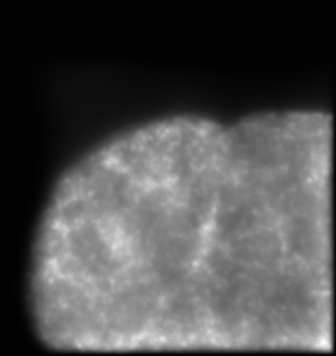

In [360]:
#Visualización de la imagen resultante
colorview(Gray, stackEstimate[:,:,52]/maximum(stackEstimate[:,:,52]))

Descomentar la siguiente celda si se desea guardar el Stack 52 de la imagen deconvolucionada (en PNG)

In [41]:
# Para guardar la imganen en formato PNG si es necesario
#save("Julia_CANAL1_100.png", stackEstimate[:,:,52]/maximum(stackEstimate[:,:,52]))

<h3 style="color: green;">@ Benchmark</h3>


En este paso, se llevará a cabo un benchmark para medir el tiempo que tarda la función de deconvolución en procesar la imagen. Utilizaremos la macro @benchmark para realizar la medición, y se podrá especificar el número de muestras (samples) a utilizar para obtener una estimación más precisa del tiempo de ejecución

In [42]:
@benchmark richardson_lucy_iterative2(image_stack, ifftshift(psf_stack), psf_bp=psf_bp, regularizer=nothing, iterations=num_iter1) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 21.362 s (0.01% GC) to evaluate,
 with a memory estimate of 523.08 MiB, over 163 allocations.

###
<h1 style="color: orange;">Canal 2</h1>

Comenzamos cargando las imágenes del Canal 2:

In [361]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = "/Users/yi/TFGNotebook/CElegans-DAPI"
psfPath2 = "/Users/yi/TFGNotebook/PSF-CElegans-DAPI"

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[1:356, 1:336, :]
psf_stack2 = load_image_stack(psfPath2)[179:534, 169:504, :]; #mitad +152

Vemos las dimensiones de las matrices 3D que se han formado con las imágenes que se han cargado previamente, el tamaño de la imagen y la PSF debe coincidir

In [362]:
# Verificar las dimensiones de las matrices 3D
println("Tamaño de la matriz 3D de la imagen: ", size(image_stack2))
println("Tipo de elemento de la imagen: ", eltype(image_stack2))
println("Tamaño de la matriz 3D de la PSF: ", size(psf_stack2))

Tamaño de la matriz 3D de la imagen: (356, 336, 104)
Tipo de elemento de la imagen: Float32
Tamaño de la matriz 3D de la PSF: (356, 336, 104)


Descomentar la siguiente celda si se desea guardar la imágen original con la que se va a trabajar:

In [45]:
#save("imagenOriginal_CANAL2.png", image_stack2[:, :,52]/maximum(image_stack2[:,:,52]))

Obtenemos el BackProjector de la PSF y seleccionamos el número de iteraciones que queremos realizar

In [363]:
# BackProjector
psf_bp2, _ = BackProjector(ifftshift(psf_stack2));

Seleccionamos es numero de iteraciones y realizamos la deconvolución sin regularizador:

In [364]:
# Numero de iteraciones
num_iter2 = 50
println("Número de iteraciones empleadas: ", num_iter2)

canal2_res = richardson_lucy_iterative2(image_stack2, ifftshift(psf_stack2), psf_bp=psf_bp2, regularizer=nothing, iterations=num_iter2);

Número de iteraciones empleadas: 50


In [365]:
guardar_cortes_centrales(canal2_res, carpeta="vistas_canal2_50iter", formato="png", color=fluorescent_green)

✅ Cortes centrales guardados en 'vistas_canal2_50iter'


Ajustamos el valor mínimo y verificamos el tamaño y el tipo de elementos que posee la matriz 3D obtenida:

In [366]:
smallValue=0.001;
stackEstimate2 = max.(canal2_res, smallValue);
stackEstimate2[:,:,52];

# Verificar las dimensiones y tipo de canal2_res
println("Tipo de la Matriz 3D deconvolucionada: ", typeof(canal2_res))
println("Dimensiones de la Matriz 3D deconvolucionada: ", size(canal2_res))

Tipo de la Matriz 3D deconvolucionada: Array{Float32, 3}
Dimensiones de la Matriz 3D deconvolucionada: (356, 336, 104)


Visualizamos el Stack 52 de la imagen deconvolucionada

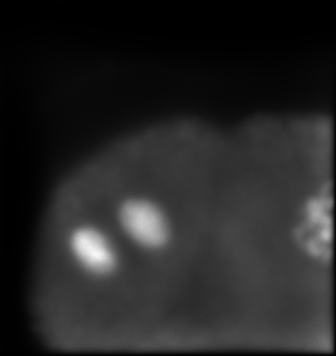

In [367]:
#Visualización de la imagen resultante
colorview(Gray, stackEstimate2[:,:,52]/maximum(stackEstimate2[:,:,52]))

Descomentar la siguiente celda si se desea guardar el Stack 52 de la imagen deconvolucionada (en PNG):

In [50]:
#save("Julia_CANAL2_120.png", stackEstimate2[:,:,52]/maximum(stackEstimate2[:,:,52]))

<h3 style="color: green;">@ Benchmark</h3>

En este paso, se llevará a cabo un benchmark para medir el tiempo que tarda la función de deconvolución en procesar la imagen. Utilizaremos la macro @benchmark para realizar la medición, y se podrá especificar el número de muestras (samples) a utilizar para obtener una estimación más precisa del tiempo de ejecución

In [51]:
@benchmark richardson_lucy_iterative2(image_stack2, ifftshift(psf_stack2), psf_bp=psf_bp2, regularizer=nothing, iterations=num_iter2) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 21.336 s (0.00% GC) to evaluate,
 with a memory estimate of 523.08 MiB, over 163 allocations.

###
<h1 style="color: orange;">Canal 3</h1>

Comenzamos cargando las imágenes del Canal 3:

In [368]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = "/Users/yi/TFGNotebook/CElegans-FITC"
psfPath3 = "/Users/yi/TFGNotebook/PSF-CElegans-FITC"

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[1:356, 1:336, :]
psf_stack3 = load_image_stack(psfPath3)[179:534, 169:504, :]; #mitad +152

Vemos las dimensiones de las matrices 3D que se han formado con las imágenes que se han cargado previamente, el tamaño de la imagen y la PSF debe coincidir

In [369]:
# Verificar las dimensiones de las matrices 3D
println("Tamaño de la matriz 3D de la imagen: ", size(image_stack3))
println("Tipo de elemento de la imagen: ", eltype(image_stack3))
println("Tamaño de la matriz 3D de la PSF: ", size(psf_stack3))

Tamaño de la matriz 3D de la imagen: (356, 336, 104)
Tipo de elemento de la imagen: Float32
Tamaño de la matriz 3D de la PSF: (356, 336, 104)


Descomentar la siguiente celda si se desea guardar la imágen original con la que se va a trabajar:

In [54]:
#save("imagenOriginal_CANAL3.png", image_stack3[:, :,52]/maximum(image_stack3[:,:,52]))

Obtenemos el BackProjector de la PSF

In [370]:
# BackProjector
psf_bp3, _ = BackProjector(ifftshift(psf_stack3));

Seleccionamos es numero de iteraciones y realizamos la deconvolución sin regularizador:

In [371]:
# Número de iteraciones
num_iter3 = 50
println("Número de iteraciones empleadas: ", num_iter3)

canal3_res = richardson_lucy_iterative2(image_stack3, ifftshift(psf_stack3), psf_bp=psf_bp3, regularizer=nothing, iterations=num_iter3);

Número de iteraciones empleadas: 50


In [372]:
guardar_cortes_centrales(canal3_res, carpeta="vistas_canal3_50iter", formato="png", color=fluorescent_blue)

✅ Cortes centrales guardados en 'vistas_canal3_50iter'


Ajustamos el valor mínimo y verificamos el tamaño y el tipo de elementos que posee la matriz 3D obtenida:

In [373]:
smallValue=0.001;
stackEstimate3 = max.(canal3_res, smallValue);
stackEstimate3[:,:,52];

# Verificar las dimensiones y tipo de canal2_res
println("Tipo de la Matriz 3D deconvolucionada: ", typeof(canal3_res))
println("Dimensiones de la Matriz 3D deconvolucionada: ", size(canal3_res))

Tipo de la Matriz 3D deconvolucionada: Array{Float32, 3}
Dimensiones de la Matriz 3D deconvolucionada: (356, 336, 104)


Visualizamos el Stack 52 de la imagen deconvolucionada

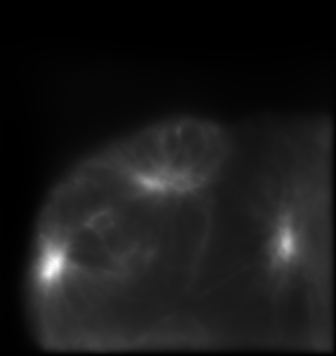

In [374]:
#Visualización de la imagen resultante
colorview(Gray, stackEstimate3[:,:,52]/maximum(stackEstimate3[:,:,52]))

Descomentar la siguiente celda si se desea guardar el Stack 52 de la imagen deconvolucionada (en PNG):

In [59]:
#save("Julia_CANAL3_240.png", stackEstimate3[:,:,52]/maximum(stackEstimate3[:,:,52]))

<h3 style="color: green;">@ Benchmark</h3>

En este paso, se llevará a cabo un benchmark para medir el tiempo que tarda la función de deconvolución en procesar la imagen. Utilizaremos la macro @benchmark para realizar la medición, y se podrá especificar el número de muestras (samples) a utilizar para obtener una estimación más precisa del tiempo de ejecución

In [60]:
@benchmark richardson_lucy_iterative2(image_stack3, ifftshift(psf_stack3), psf_bp=psf_bp3, regularizer=nothing, iterations=num_iter3) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 21.334 s (0.00% GC) to evaluate,
 with a memory estimate of 523.08 MiB, over 163 allocations.

###
<h1 style="color: orange;">Combinación de canales</h1>

In [28]:
# Función para normalizar una imagen
function normalize(image::AbstractArray)
    max_val = maximum(image)
    return (image) ./ (max_val)
end

normalize (generic function with 1 method)

Normalizamos los canales:

In [29]:
# Normalizar los canales
deconvolved_stack_R = normalize(stackEstimate);
deconvolved_stack_G = normalize(stackEstimate2);
deconvolved_stack_B = normalize(stackEstimate3);

In [30]:

# Función para crear una imagen RGB para la visualización
function create_rgb_image(r::AbstractArray, g::AbstractArray, b::AbstractArray)
    # Verificar que todas las dimensiones sean iguales
    height, width = size(r)
    if size(g) != (height, width) || size(b) != (height, width)
        throw(ArgumentError("Las dimensiones de las imágenes R, G y B deben coincidir."))
    end

    # Crear una matriz de imágenes RGB
    rgb_image = Array{RGB{Float32}, 2}(undef, height, width)
    rgb_image[:, :] .= RGB{Float32}[RGB(r[i, j], g[i, j], b[i, j]) for i in 1:height, j in 1:width]
    return rgb_image
end


create_rgb_image (generic function with 1 method)

Imagen deconvolucionada con los 3 canales juntos:

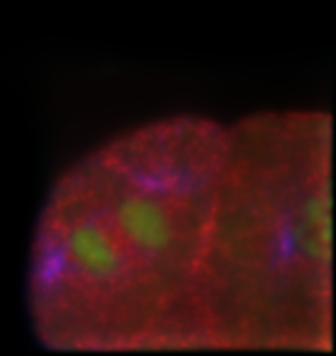

In [31]:

# Combinar los canales en una imagen RGB
deconvolved_image_color = create_rgb_image(deconvolved_stack_R[ :, :,52],
                                           deconvolved_stack_G[ :, :,52],
                                           deconvolved_stack_B[ :, :,52])


Comparamos la imagen original con la deconvolucionada:

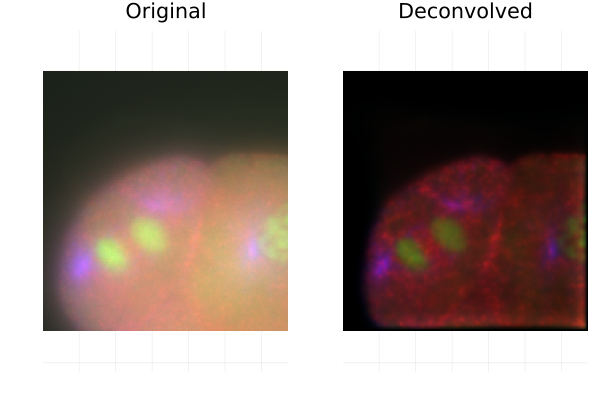

In [32]:

# Normalizar y combinar los planos para la visualización
original_image_rgb = create_rgb_image(normalize(image_stack[:, :, 52]),
                                       normalize(image_stack2[:, :,52]),
                                       normalize(image_stack3[:, :,52]))

# Guardar la imagen deconvolucionada en PNG
#save("deconvolved_CElegans_Julia.png", deconvolved_image_color)
#save("deconvolved_CElegans_Julia_CANAL1.png", deconvolved_stack_R[:, :,52])
# Mostrar las imágenes
plot(
    heatmap(original_image_rgb, title="Original", axis=false, color=:inferno),
    heatmap(deconvolved_image_color, title="Deconvolved", axis=false, color=:inferno),
    layout=(1, 2)
)


Descomentar la siguiente celda si se quiere guardar la imagen combinada en formato PNG:

In [33]:
#save("Julia_NEWMejorada.png", deconvolved_image_color)